Install PyTorch

In [14]:
pip install torch torchvision

importing all the libraries

In [1]:
# importing the libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

Check the version of PyTorch 

In [2]:
# version of pytorch
print(torch.__version__)

1.9.0+cu102


We will perform some transformations on the images, like normalizing the pixel values, so, let’s define those transformations

In [3]:
# transformations to be applied on images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

load the training and testing set of the MNIST dataset

In [4]:
# defining the training and testing set
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



I have defined the train and test loader which will help us to load the training and test set in batches. I will define the batch size as 64

In [5]:
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

look at the summary of the training set first

In [6]:
# shape of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In each batch, we have 64 images, each of size 28,28 and for each image, we have a corresponding label

Let’s visualize a training image and see how it looks

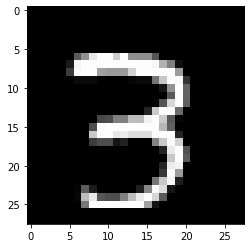

In [8]:
 # visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

It’s an image of number 3. Similarly, let’s visualize the test set image:

In [9]:
# shape of validation data
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Defining Model Architecture

We will be using a CNN model here. So let us define and train this model:

In [10]:
# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 7 * 7, 10)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

also define the optimizer and loss function then we will look at the summary of this model

In [11]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


we have 2 convolutional layers that will help to extract features from the images. Features from these convolutional layers are passed to the fully connected layer which classifies the images into their respective class. Now our model architecture is ready, let’s train this model for 10 epochs:

In [12]:
for i in range(10):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 - Training loss: 0.18167077533916623
Epoch 2 - Training loss: 0.09642818319335231
Epoch 3 - Training loss: 0.08447062150701316
Epoch 4 - Training loss: 0.07908473138003422
Epoch 5 - Training loss: 0.07396742634535797
Epoch 6 - Training loss: 0.07173104728557178
Epoch 7 - Training loss: 0.07035258592544262
Epoch 8 - Training loss: 0.06627328672494961
Epoch 9 - Training loss: 0.06541691376750212
Epoch 10 - Training loss: 0.06280141431358713


You can see that the training loss is decreasing with an increasing number of epochs. This means that our model is learning patterns from the training set. Let’s check the performance of this model on the test set:

In [13]:
# getting predictions on test set and measuring the performance
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9625


So, we tested a total of 10000 images and the model is around 96% accurate in predicting the labels for test images